### Fundamentals of Natural Language Processing
# Negation and Uncertainty Detection using a Machine-Learning Based Approach

*Authors:*

> *Anna Blanco, Agustina Lazzati, Stanislav Bultaskii, Queralt Salvadó*

*Aims:*
> Our goal is to train various Machine Learning based models for each of the two sub-tasks (detection of negation and uncertainty signals, and detection of the negation and uncertainty scopes). In order to do so, we followed the implementation method described by *Enger, Velldal, and Øvrelid (2017)*, which employs a maximum-margin approach for negation detection. However, for our particular application, we also included uncertainty cues and scope detection.

*References:* 
<br>
> Enger, M., Velldal, E., & Øvrelid, L. (2017). *An open-source tool for negation detection: A maximum-margin approach*. Proceedings of the Workshop on Computational Semantics Beyond Events and Roles (SemBEaR), 64–69.

---

We can erase this if you want but the thing is that we need to use the environment that queralt did. You need to write some commands to have the nlp_project (Python) as we have specific libraries. 

I did that and in the preprocessing it worked but here in order to work I had to run this command above, if it is not needed just avoid them!

In [2]:
import spacy

# Check installed models
print(spacy.util.get_installed_models())


['es_core_news_sm']


In [3]:
#!python -m spacy download es_core_news_sm


In [4]:
# Import necessary libraries and functions
import json
import spacy
from collections import defaultdict
import re
import pandas as pd
from preprocessing import df_svm_neg_test, df_svm_neg_train, df_svm_neg_test, df_svm_unc_train, df_svm_unc_test, df_crf_neg_train, df_crf_neg_test, df_crf_unc_train, df_crf_unc_test

   sentence_id  token_id      word     lemma    pos prefix suffix  is_punct  \
0            0         0                      SPACE                       0   
1            1         0        nº        nº   NOUN     nº     nº         0   
2            1         1  historia  historia   NOUN    his    ria         0   
3            1         2   clinica   clinico    ADJ    cli    ica         0   
4            1         3         :         :  PUNCT      :      :         1   

   is_redacted    dep head_pos  in_single_word_cues  in_affixal_cues  \
0            0    dep    SPACE                    0                0   
1            0    det     NOUN                    0                0   
2            0   ROOT     NOUN                    0                0   
3            0   amod     NOUN                    0                0   
4            0  punct     NOUN                    0                0   

   ends_with_ment  neg_cue_label  
0               0              0  
1               0     

## CUE DETECTION USING SVM

First of all, we'll need to vectorize:

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer

def prepare_dataframe_for_svm(df, label_col):
    """
    Converts a DataFrame into features and labels for training.
    """
    drop_cols = ["sentence_id", "token_id", label_col]
    feature_dicts = df.drop(columns=drop_cols).to_dict(orient="records")
    labels = df[label_col].tolist()

    vectorizer = DictVectorizer(sparse=True)
    X = vectorizer.fit_transform(feature_dicts)
    y = labels

    return X, y, vectorizer


def train_and_evaluate_svm(df_train, df_test, label_col, model_name):
    """
    Trains and evaluates an SVM model, returning key data for further use.
    """
    # Prepare data
    X_train, y_train, vec = prepare_dataframe_for_svm(df_train, label_col)
    X_test = vec.transform(df_test.drop(columns=["sentence_id", "token_id", label_col]).to_dict(orient="records"))
    y_test = df_test[label_col].tolist()

    # Define and train the SVM model
    svm_model = LinearSVC(class_weight="balanced", max_iter=5000, random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)

    # Report
    print(f"\n--- Evaluation for {model_name} ---")
    print(classification_report(y_test, y_pred, digits=4))


    return X_train, y_train, X_test, y_test, y_pred, svm_model, vec

### SVM for negation cue detection

In [6]:
X_train_negsvm, y_train_negsvm, X_test_negsvm, y_test_negsvm, y_pred_negsvm, neg_svm_model, vectorizer_neg = train_and_evaluate_svm(
    df_train=df_svm_neg_train,
    df_test=df_svm_neg_test,
    label_col="neg_cue_label",
    model_name="svm_negation_cue"
)

c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



--- Evaluation for svm_negation_cue ---
              precision    recall  f1-score   support

           0     0.9999    0.9984    0.9992     64399
           1     0.9163    0.9956    0.9543      1132

    accuracy                         0.9984     65531
   macro avg     0.9581    0.9970    0.9767     65531
weighted avg     0.9985    0.9984    0.9984     65531



c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### SVM for uncertainty cue detection

In [7]:
X_train_svmunc, y_train_svmunc, X_test_svmunc, y_test_svmunc, y_pred_svmunc, model_svmunc, vectorizer_unc = train_and_evaluate_svm(
    df_train=df_svm_unc_train,
    df_test=df_svm_unc_test,
    label_col="unc_cue_label",
    model_name="svm_uncertainty_cue"
)

c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



--- Evaluation for svm_uncertainty_cue ---
              precision    recall  f1-score   support

           0     1.0000    0.9309    0.9642    251284
           1     0.0375    0.9869    0.0723       686

    accuracy                         0.9311    251970
   macro avg     0.5187    0.9589    0.5183    251970
weighted avg     0.9973    0.9311    0.9618    251970



In [8]:
def balance_training_data(df, label_col, neg_ratio=4, seed=42):
    positives = df[df[label_col] == 1]
    negatives = df[df[label_col] == 0].sample(n=len(positives) * neg_ratio, random_state=seed)
    df_balanced = pd.concat([positives, negatives]).sample(frac=1, random_state=seed).reset_index(drop=True)
    return df_balanced

df_balanced_unc_train = balance_training_data(df_svm_unc_train, label_col="unc_cue_label", neg_ratio=4)
print(df_balanced_unc_train["unc_cue_label"].value_counts())

0    2744
1     686
Name: unc_cue_label, dtype: int64


In [9]:
X_train_svmunc, y_train_svmunc, X_test_svmunc, y_test_svmunc, y_pred_svmunc, model_svmunc, vectorizer = train_and_evaluate_svm(
    df_train=df_balanced_unc_train,
    df_test=df_svm_unc_test,
    label_col="unc_cue_label",
    model_name="svm_uncertainty_cue_balanced"
)

c:\Users\Agusl\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



--- Evaluation for svm_uncertainty_cue_balanced ---
              precision    recall  f1-score   support

           0     1.0000    0.9286    0.9630    251284
           1     0.0364    0.9869    0.0701       686

    accuracy                         0.9287    251970
   macro avg     0.5182    0.9577    0.5165    251970
weighted avg     0.9973    0.9287    0.9605    251970



In [25]:
def compute_per_label_accuracy(y_true, y_pred, label_mapping, title="Per-label Accuracy"):
    # Map numeric labels to readable ones (if needed)
    y_true_named = [label_mapping.get(y, y) for y in y_true]
    y_pred_named = [label_mapping.get(y, y) for y in y_pred]

    # Get all relevant labels, excluding "O" if applicable
    unique_labels = sorted(set(label for label in y_true_named if label != 'O'))

    # Compute accuracy per label (correct predictions / total true instances)
    per_label_accuracies = {}
    for label in unique_labels:
        total = sum(1 for y in y_true_named if y == label)
        correct = sum(1 for yt, yp in zip(y_true_named, y_pred_named) if yt == label and yp == label)
        per_label_accuracies[label] = correct / total if total > 0 else 0.0

    # Print results
    print(f"\n{title}:")
    for label, acc in per_label_accuracies.items():
        print(f"{label:<10}: {acc:.4f}")


In [26]:
compute_per_label_accuracy(
    y_true=y_test_svmunc,
    y_pred=y_pred_svmunc,
    label_mapping={1: "UNC", 0: "NOT UNC"},
    title="Per-label Accuracy for SVM Uncertainty Cue Detection"
)

compute_per_label_accuracy(
    y_true=y_test_negsvm,
    y_pred=y_pred_negsvm,
    label_mapping={1: "NEG", 0: "NOT NEG"},
    title="Per-label Accuracy for SVM Negation Cue Detection"
)



Per-label Accuracy for SVM Uncertainty Cue Detection:
NOT UNC   : 0.9286
UNC       : 0.9869

Per-label Accuracy for SVM Negation Cue Detection:
NEG       : 0.9956
NOT NEG   : 0.9984


## SCOPE DETECTION USING CRF

In [11]:
# pip install sklearn-crfsuite

We'll use CRF BIO tagging:

**BIO tagging** is a way to label each word in a sentence to show if it is part of a scope (like negation or uncertainty). The labels are:

* **B** for the **Beginning** of the scope
* **I** for **Inside** the scope
* **O** for **Outside** the scope

We use BIO tagging to help machine learning models, like **CRFs (Conditional Random Fields)**, understand where a scope starts and ends. For example, if a sentence has a negation like “No tiene fiebre”, BIO tagging shows that “No” is the beginning (**B-SCOPE**) and “tiene fiebre” is inside the scope (**I-SCOPE**), while other words would be labeled **O** if they are not part of it.

Using BIO makes it easier for the model to learn patterns and detect complete scopes correctly, not just single words. 


In [12]:
#   IM GETTING ALL THE NEGATION AND THE UNC CUES FROM TRAIN DATAFRAME, 
#   maybe it should be done with the svm but i dont how. 
neg_cues = set()
unc_cues = set()
for _, row in df_svm_neg_train.iterrows():
    if row['neg_cue_label'] == 1:
        neg_cues.add(row['word'].lower())

for _, row in df_svm_unc_train.iterrows():
    if row['unc_cue_label'] == 1:
        unc_cues.add(row['word'].lower())


In [13]:
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics

def to_bio_labels(labels, label_type="SCOPE"):
    # Convert lists of binary labels (0/1) into BIO tagging format with custom suffixes
    bio_labels = []
    
    # Map original suffixes to new ones
    if "neg" in label_type.lower():
        prefix = "NSCO"   # Instead of NEG_SCOPE
    elif "unc" in label_type.lower():
        prefix = "UNSCO"  # Instead of UNC_SCOPE
    else:
        prefix = label_type.upper()  # fallback

    for sent in labels:
        bio = []
        prev = 0
        for i, tag in enumerate(sent):
            if tag == 1:
                if i == 0 or prev == 0:
                    bio.append(f'B-{prefix}')
                else:
                    bio.append(f'I-{prefix}')
            else:
                bio.append('O')
            prev = tag
        bio_labels.append(bio)
    return bio_labels

def df_to_crf_format(df, task, neg_cues=neg_cues, unc_cues=unc_cues):
    """
    Convert a DataFrame into a list of feature dictionaries per sentence for CRF input.
    Includes original features + contextual features + lexicon-based features.
    
    Parameters:
        df (pd.DataFrame): must contain columns like 'word', 'pos', 'prefix', 'suffix', etc.

    Returns:
        List of list of feature dicts (one per token, grouped by sentence)
    """
    sentences = []
    grouped = df.groupby("sentence_id")

    for _, group in grouped:
        sentence = []
        group = group.reset_index(drop=True)  # Reset index so we can use idx in loop

        for idx, row in group.iterrows():
            word_lower = row['word'].lower()

            features = {
                'word.lower()': word_lower,
                'word.isupper()': row['word'].isupper(),
                'word.istitle()': row['word'].istitle(),
                'pos': row['pos'],
                'pos_prefix': row['pos'][:2] if isinstance(row['pos'], str) else 'NA',
                'prefix': row['prefix'],
                'suffix': row['suffix'],
                'is_punct': row['is_punct'],
                'in_single_word_cues': row['in_single_word_cues'],
                'in_affixal_cues': row['in_affixal_cues'],
                'ends_with_ment': row['ends_with_ment'],
                'has_neg_prefix': word_lower.startswith(('un', 'in', 'non', 'dis')),
                'has_neg_suffix': word_lower.endswith(('less', "n't")),
                'is_modal': word_lower in unc_cues if task == "UNC" else word_lower in neg_cues
            }
    
            # dependency features
            if 'dep' in row and 'head_word' in row and 'head_pos' in row:
                features.update({
                    'dep_label': row['dep'],
                    'head_word': str(row['head_word']).lower(),
                    'head_pos': row['head_pos']
                })

            # Contextual features: previous and next token
            if idx > 0:
                prev_row = group.iloc[idx - 1]
                features.update({
                    '-1:word.lower()': prev_row['word'].lower(),
                    '-1:pos': prev_row['pos']
                })
            else:
                features['BOS'] = True  # Beginning of sentence

            if idx < len(group) - 1:
                next_row = group.iloc[idx + 1]
                features.update({
                    '+1:word.lower()': next_row['word'].lower(),
                    '+1:pos': next_row['pos']
                })
            else:
                features['EOS'] = True  # End of sentence

            sentence.append(features)
        sentences.append(sentence)

    return sentences


def df_to_labels(df, label_col):
    # Extracts label sequences from the DataFrame, grouped by sentence
    label_sequences = []
    grouped = df.groupby("sentence_id")
    for _, group in grouped:
        label_list = group[label_col].tolist()
        label_sequences.append(label_list)
    return label_sequences


In [14]:
# Train + evaluate CRF model
def train_and_evaluate_crf(df_train, df_test, label_col):
    # Trains and evaluates a CRF model for BIO tagging using specified label column (e.g., 'neg_scope_label')
    scope_type = "NEG" if "neg" in label_col.lower() else "UNC"

    X_train = df_to_crf_format(df_train, scope_type)
    y_train_raw = df_to_labels(df_train, label_col)
    y_train = to_bio_labels(y_train_raw, label_type=scope_type)

    X_test = df_to_crf_format(df_test, scope_type)
    y_test_raw = df_to_labels(df_test, label_col)
    y_test = to_bio_labels(y_test_raw, label_type=scope_type)

    crf = CRF(algorithm='lbfgs', 
              c1=0.1, c2=0.1,
              max_iterations=100, all_possible_transitions=True)
    
    crf.fit(X_train, y_train)
    y_pred = crf.predict(X_test)

    print(f"CRF Evaluation for: {label_col.upper()}")
    print(metrics.flat_classification_report(y_test, y_pred, digits=4))   
    
    return X_test, y_test, y_pred  # Return these variables for further use


### CRF for negation scope detection

In [15]:
# CRF BIO tagging evaluation for NEGATION scopes
X_test_NEG, y_test_NEG, y_pred_NEG = train_and_evaluate_crf(df_crf_neg_train, df_crf_neg_test, "neg_scope_label")

CRF Evaluation for: NEG_SCOPE_LABEL
              precision    recall  f1-score   support

      B-NSCO     0.9633    0.9066    0.9341      1071
      I-NSCO     0.8965    0.7831    0.8360      2522
           O     0.9897    0.9958    0.9927     61938

    accuracy                         0.9862     65531
   macro avg     0.9498    0.8952    0.9209     65531
weighted avg     0.9857    0.9862    0.9857     65531



### CRF for uncertainty scope detection

In [16]:
# CRF BIO tagging evaluation for UNCERTAINTY scopes
X_test_UNC, y_test_UNC, y_pred_UNC = train_and_evaluate_crf(df_crf_unc_train, df_crf_unc_test, "unc_scope_label")

CRF Evaluation for: UNC_SCOPE_LABEL
              precision    recall  f1-score   support

     B-UNSCO     0.7963    0.3333    0.4699       129
     I-UNSCO     0.6590    0.3936    0.4928       437
           O     0.9947    0.9985    0.9966     64965

    accuracy                         0.9932     65531
   macro avg     0.8167    0.5751    0.6531     65531
weighted avg     0.9921    0.9932    0.9922     65531



In [17]:
# TABLE WITH ALL COMBINED EXCLUDING THE OUTOFSCOPE: 
# Combine the BIO label sequences
y_test_all = y_test_NEG + y_test_UNC
y_pred_all = y_pred_NEG + y_pred_UNC

# Get all labels except 'O'
all_labels = set(label for seq in y_test_all for label in seq if label != 'O')
all_labels = sorted(all_labels)

# Print overall evaluation
print("Overall Evaluation (NEG + UNC scopes):")
print(metrics.flat_classification_report(
    y_test_all, y_pred_all, labels=all_labels, digits=4))

Overall Evaluation (NEG + UNC scopes):
              precision    recall  f1-score   support

      B-NSCO     0.9633    0.9066    0.9341      1071
     B-UNSCO     0.7963    0.3333    0.4699       129
      I-NSCO     0.8965    0.7831    0.8360      2522
     I-UNSCO     0.6590    0.3936    0.4928       437

   micro avg     0.8965    0.7600    0.8226      4159
   macro avg     0.8288    0.6042    0.6832      4159
weighted avg     0.8856    0.7600    0.8138      4159



In [ ]:
# Flatten the sequences
true_labels = [label for seq in y_test_all for label in seq]
pred_labels = [label for seq in y_pred_all for label in seq]

# Call the function
compute_per_label_accuracy(
    y_true=true_labels,
    y_pred=pred_labels,
    label_mapping={},
    title="Per-label Accuracy for CRF Scope"
)


Per-label Accuracy for CRF Negation Scope:
B-NSCO    : 0.9066
B-UNSCO   : 0.3333
I-NSCO    : 0.7831
I-UNSCO   : 0.3936


## Printing CRF Predictions vs. True labels
We display sample sentences with predicted and true BIO tags shown as `[true_tag|pred_tag]` next to each word, only if at least one tag isn't `'O'`. This highlights where the model correctly identifies scopes or makes mistakes, helping us quickly assess its performance on meaningful cases.

In [57]:
def print_crf_predictions(df, y_true, y_pred, sentence_idx=0):
    """
    Print the whole sentence in one line, adding true and predicted BIO tags in brackets next to tokens
    only if the tags are not 'O' (for BIO) or '0' (for SVM).
    Format per token: word[true_tag|pred_tag] if either tag != 'O' or '0', else just word.
    """
    grouped = df.groupby("sentence_id")
    sentence_ids = list(grouped.groups.keys())

    if sentence_idx >= len(sentence_ids):
        print(f"Invalid sentence index {sentence_idx}. Max allowed: {len(sentence_ids) - 1}")
        return

    sentence_id = sentence_ids[sentence_idx]
    sentence_df = grouped.get_group(sentence_id).reset_index(drop=True)
    
    output_tokens = []
    for i, row in sentence_df.iterrows():
        word = row['word']
        true_label = y_true[sentence_idx][i]
        pred_label = y_pred[sentence_idx][i]

        # Show tags only if either true or pred label is not neutral ('O' for BIO, '0' for SVM)
        if (true_label != 'O' and true_label != 0 and true_label != '0') or (pred_label != 'O' and pred_label != 0 and pred_label != '0'):
            display_word = f"{word} [{true_label}|{pred_label}]"
        else:
            display_word = word

        output_tokens.append(display_word)

    print(f"\n--- Sentence ID {sentence_id} ---")
    print(" ".join(output_tokens))


In [ ]:
shown = 0
max_to_show = 10

print('NSCO EXAMPLES --------------\n')
for i in range(len(y_test_NEG)):
    if any(tag != 'O' for tag in y_test_NEG[i]) or any(tag != 'O' for tag in y_pred_NEG[i]):
        print_crf_predictions(df_crf_neg_test, y_test_NEG, y_pred_NEG, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break


--- Sentence ID 1 ---
nº historia clinica : * * * * * * * * nºepisodi : * * * * * * * * sexe : dona data de naixement : 12.05.1977 edat : 42 anys procedencia aguts servei obstetricia data d'ingres 27.09.2019 data d'alta 01.10.2019 13:00:00 ates per * * * * * * * * * * * * * * * * * , * * * * * * * * * * * * * * ; * * * * * * * * * * * * * * * * * , * * * * * informe d'alta d'hospitalitzacio motiu d'ingres induccion al parto por pequeño para la edad gestacional ( peg ) antecedents no alergias [B-NSCO|B-NSCO] medicamentosas [I-NSCO|I-NSCO] conocidas antcededentes medico-quirurgicos : protesis mamaria , adenoidectomia niega habitos [B-NSCO|B-NSCO] toxicos [I-NSCO|I-NSCO] medicacio habitual anafranil25 mg/ diario .

--- Sentence ID 10 ---
vih [B-NSCO|B-NSCO] negativo .

--- Sentence ID 11 ---
serologias : rubeola no inmune [B-NSCO|B-NSCO] , toxoplasma no immune [B-NSCO|B-NSCO] , lues [B-NSCO|B-NSCO] vih [I-NSCO|I-NSCO] , [I-NSCO|I-NSCO] vhb [I-NSCO|I-NSCO] y [I-NSCO|I-NSCO] vhc [I-NSCO|I-

In [ ]:
shown = 0
max_to_show = 10
print('UNSCO EXAMPLES --------------\n')
for i in range(len(y_test_UNC)):
    if any(tag != 'O' for tag in y_test_UNC[i]) or any(tag != 'O' for tag in y_pred_UNC[i]):
        print_crf_predictions(df_crf_neg_test, y_test_UNC, y_pred_UNC, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break


--- Sentence ID 138 ---
dado cuadro clinico y analitico que podria ser [B-UNSCO|O] compatible [I-UNSCO|O] con [I-UNSCO|O] sd [I-UNSCO|O] mononucleosido [I-UNSCO|O] se amplia estudio con determinacion de pcr de parvovirus b19 , toxoplasma y vhh-6 , con resultados pendientes .

--- Sentence ID 140 ---
orientacio diagnostica b34.9 infeccio virica no especificada neutropenia autolimitada fiebre de origen desconocido , posible viriasis [B-UNSCO|B-UNSCO] . [O|I-UNSCO]

--- Sentence ID 156 ---
antecedentes patologicos - elevacion de transaminasas posiblemente secundario [B-UNSCO|O] a [I-UNSCO|O] consumo [I-UNSCO|O] enolico [I-UNSCO|O] . [I-UNSCO|O]

--- Sentence ID 188 ---
hipoestesia simetrica en mmii hasta abdomen ( sin claro nivel [B-UNSCO|O] ) [I-UNSCO|O] .

--- Sentence ID 193 ---
atrofia hipotenar y posible atrofia [B-UNSCO|B-UNSCO] interoseos [I-UNSCO|I-UNSCO] ( paciente refiere que siempre ha permanecido asi ) .

--- Sentence ID 228 ---
por las caracteristicas encontradas , sugiere o

In [ ]:
def group_labels_by_sentence(df, labels):
    grouped = df.groupby("sentence_id")
    grouped_labels = []
    start = 0
    for sentence_id, group in grouped:
        length = len(group)
        grouped_labels.append(labels[start:start+length])
        start += length
    return grouped_labels

# Group your flat label lists by sentence
y_test_svmunc_grouped = group_labels_by_sentence(df_svm_unc_test, y_test_svmunc)
y_pred_svmunc_grouped = group_labels_by_sentence(df_svm_unc_test, y_pred_svmunc)

shown = 0
max_to_show = 10

print('UNCERTANTY EXAMPLES --------------\n')
for i in range(len(y_test_svmunc_grouped)):
    # Check if any tag is NOT '0' or 0 in true or predicted labels
    if any(tag != '0' and tag != 0 for tag in y_test_svmunc_grouped[i]) or any(tag != '0' and tag != 0 for tag in y_pred_svmunc_grouped[i]):
        print_crf_predictions(df_svm_unc_test, y_test_svmunc_grouped, y_pred_svmunc_grouped, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break



--- Sentence ID 1 ---
nº historia clinica : * * * * * * * * nºepisodi : * * * * * * * * sexe : home data de [0|1] naixement : 16.05.1936 edat : 82 anys procedencia cex mateix hosp servei urologia data d'ingres 24.07.2018 data d'alta 25.07.2018 08:54:04 ates per * * * * * * * * * * * * * * * , * * * * * ; * * * * * * * * * * * * * * * * , * * * * * * informe d'alta d'hospitalitzacio motiu d'ingres paciente que ingresa de [0|1] forma programada para realizacion de [0|1] uretrotomia interna .

--- Sentence ID 3 ---
no [0|1] habitos toxicos .

--- Sentence ID 4 ---
antecedentes medicos : bloqueo auriculoventricular de [0|1] primer grado hipertension arterial .

--- Sentence ID 5 ---
diverticulosis extensa insuficiencia renal cronica colelitiasis antecedentes quirurgicos : exeresis de [0|1] lesiones cutaneas con [0|1] anestesia local protesis total de [0|1] cadera cordectomia herniorrafia inguinal proces actual varon de [0|1] 81a que a raiz de [0|1] episodio de [0|1] hematuria macroscopica

In [ ]:
print('NEGATION EXAMPLES --------------\n')
# Group your flat label lists by sentence
y_test_svmneg_grouped = group_labels_by_sentence(df_svm_neg_test, y_test_negsvm)
y_pred_svmneg_grouped = group_labels_by_sentence(df_svm_neg_test, y_pred_negsvm)

shown = 0
max_to_show = 10

for i in range(len(y_test_svmneg_grouped)):
    if any(tag != '0' and tag != 0 for tag in y_test_svmneg_grouped[i]) or any(tag != '0' and tag != 0 for tag in y_pred_svmneg_grouped[i]):
        print_crf_predictions(df_svm_neg_test, y_test_svmneg_grouped, y_pred_svmneg_grouped, sentence_idx=i)
        shown += 1
        if shown >= max_to_show:
            break


--- Sentence ID 1 ---
nº historia clinica : * * * * * * * * nºepisodi : * * * * * * * * sexe : dona data de naixement : 12.05.1977 edat : 42 anys procedencia aguts servei obstetricia data d'ingres 27.09.2019 data d'alta 01.10.2019 13:00:00 ates per * * * * * * * * * * * * * * * * * , * * * * * * * * * * * * * * ; * * * * * * * * * * * * * * * * * , * * * * * informe d'alta d'hospitalitzacio motiu d'ingres induccion al parto por pequeño para la edad gestacional ( peg ) antecedents no [1|1] alergias medicamentosas conocidas antcededentes medico-quirurgicos : protesis mamaria , adenoidectomia niega [1|1] habitos toxicos medicacio habitual anafranil25 mg/ diario .

--- Sentence ID 10 ---
vih negativo [1|1] .

--- Sentence ID 11 ---
serologias : rubeola no [1|1] inmune , toxoplasma no [1|1] immune , lues vih , vhb y vhc negativos [1|1] .

--- Sentence ID 12 ---
- triple screening : 1/14045 down i 1/60540 edwards - riesgo de pe : bajo riesgo - o'sullivan : 216mg / dl - sgb negativo [0|1] - 

### Overall Results: SVM + CRF

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def flatten(seq_list):
    return [label for seq in seq_list for label in seq]

# Cue detection: true and predicted labels
cue_true = df_svm_neg_test["neg_cue_label"].tolist() + df_svm_unc_test["unc_cue_label"].tolist()
cue_pred = list(neg_svm_model.predict(X_test_negsvm)) + list(model_svmunc.predict(X_test_svmunc))

# Scope detection: true and predicted
scope_true = flatten(y_test_NEG) + flatten(y_test_UNC)
scope_pred = flatten(y_pred_NEG) + flatten(y_pred_UNC)

# Filter out neutral classes (non-cues and non-scopes)
cue_true_filtered = [true for true, pred in zip(cue_true, cue_pred) if true != '0']
cue_pred_filtered = [pred for true, pred in zip(cue_true, cue_pred) if true != '0']

scope_true_filtered = [true for true, pred in zip(scope_true, scope_pred) if true != 'O']
scope_pred_filtered = [pred for true, pred in zip(scope_true, scope_pred) if true != 'O']

# Combine filtered cue and scope labels
y_true_all = cue_true_filtered + scope_true_filtered
y_pred_all = cue_pred_filtered + scope_pred_filtered

# Calculate evaluation metrics
accuracy = accuracy_score(y_true_all, y_pred_all)
precision = precision_score(y_true_all, y_pred_all, average="weighted", zero_division=0)
recall = recall_score(y_true_all, y_pred_all, average="weighted", zero_division=0)
f1 = f1_score(y_true_all, y_pred_all, average="weighted", zero_division=0)

In [40]:
# Output the results
print("\nFiltered Overall Evaluation (Cue + Scope Detection):")
print(f"{'Metric':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print(f"{'Overall':<10}  {accuracy:.4f}     {precision:.4f}    {recall:.4f}      {f1:.4f}")



Filtered Overall Evaluation (Cue + Scope Detection):
Metric     Accuracy   Precision  Recall     F1 Score  
Overall     0.9407     0.9948    0.9407      0.9645


In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_task_confusion_matrices(
    y_test_negsvm, y_pred_negsvm,
    y_test_svmunc, y_pred_svmunc,
    y_test_NEG, y_pred_NEG,
    y_test_UNC, y_pred_UNC
):
    def binary_label_map(y, label_type):
        return [f"{label_type}" if v == 1 else f"NOT {label_type}" for v in y]

    def flatten(seqs):
        return [label for seq in seqs for label in seq]

    def plot_cm(ax, y_true, y_pred, labels, title):
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)

    # Convert 0/1 to string labels
    y_test_neg_named = binary_label_map(y_test_negsvm, "NEG")
    y_pred_neg_named = binary_label_map(y_pred_negsvm, "NEG")
    y_test_unc_named = binary_label_map(y_test_svmunc, "UNC")
    y_pred_unc_named = binary_label_map(y_pred_svmunc, "UNC")

    # Flatten scope labels
    y_test_neg_scope = flatten(y_test_NEG)
    y_pred_neg_scope = flatten(y_pred_NEG)
    y_test_unc_scope = flatten(y_test_UNC)
    y_pred_unc_scope = flatten(y_pred_UNC)

    # Label sets
    neg_cue_labels = ["NOT NEG", "NEG"]
    unc_cue_labels = ["NOT UNC", "UNC"]
    neg_scope_labels = sorted(set(y_test_neg_scope + y_pred_neg_scope))
    unc_scope_labels = sorted(set(y_test_unc_scope + y_pred_unc_scope))

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    plot_cm(axs[0, 0], y_test_neg_named, y_pred_neg_named, neg_cue_labels, "Confusion Matrix for NEG")
    plot_cm(axs[0, 1], y_test_unc_named, y_pred_unc_named, unc_cue_labels, "Confusion Matrix for UNC")
    plot_cm(axs[1, 0], y_test_neg_scope, y_pred_neg_scope, neg_scope_labels, "Confusion Matrix for NSCO")
    plot_cm(axs[1, 1], y_test_unc_scope, y_pred_unc_scope, unc_scope_labels, "Confusion Matrix for USCO")

    plt.tight_layout()
    plt.show()


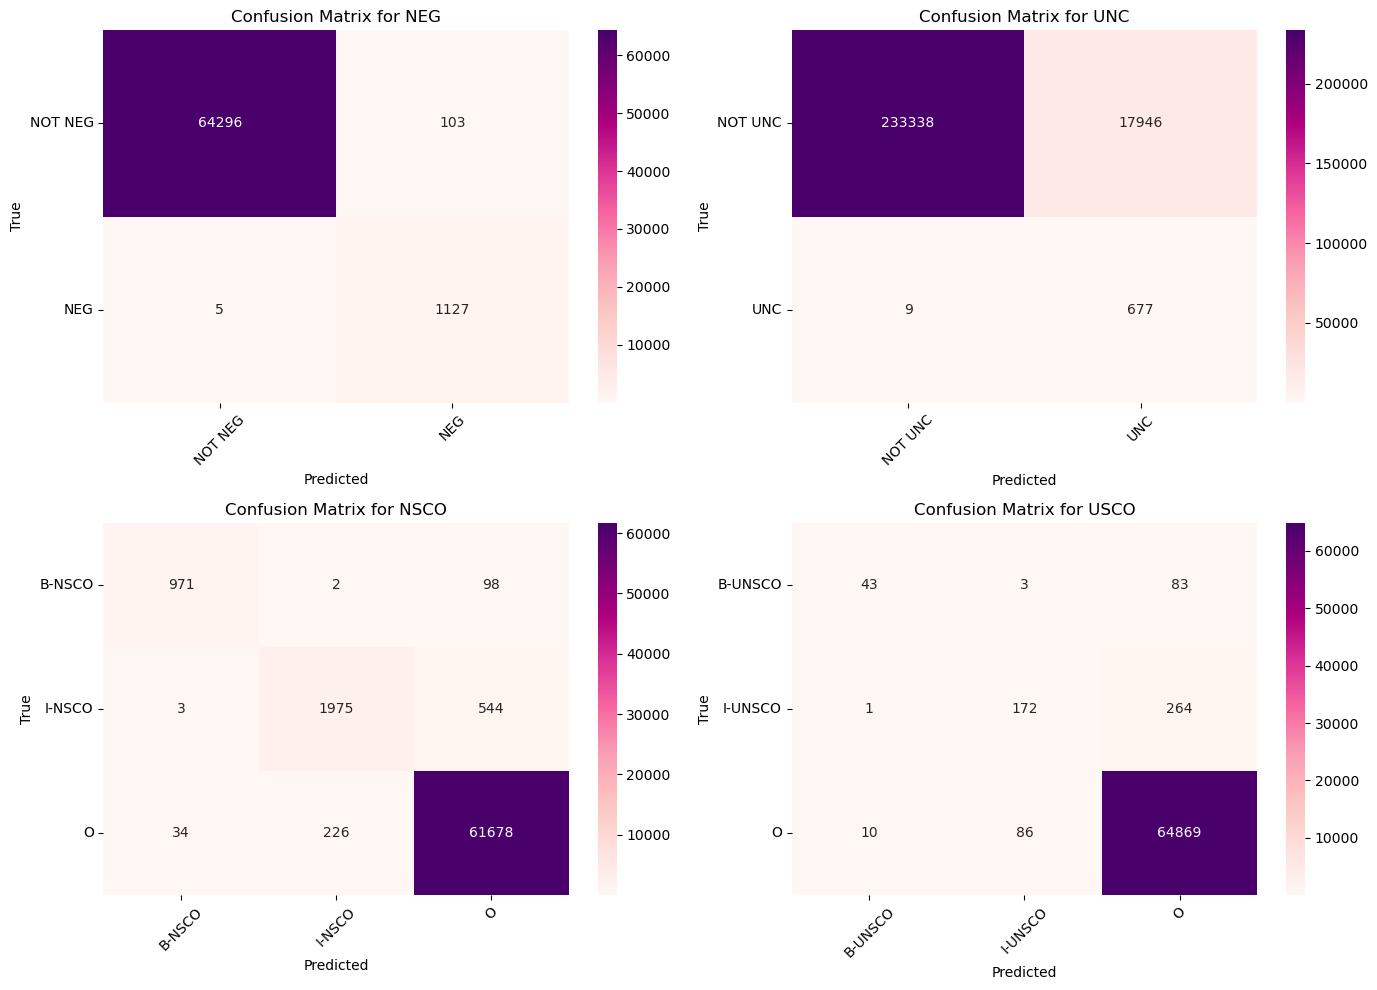

In [24]:
plot_task_confusion_matrices(
    y_test_negsvm, y_pred_negsvm,
    y_test_svmunc, y_pred_svmunc,
    y_test_NEG, y_pred_NEG,
    y_test_UNC, y_pred_UNC
)
